# Capstone Project - HOW TO IMPROVE THE LIVABILITY OF SOME OKLAHOMAN CITIES

## Import libraries, install geopy and folium

In [1]:
import numpy as np # library to handle data in a vectorized manner
from numpy.linalg import norm # Function to calculate euclidean distances between 2 vectors.

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         392 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch

## Prepare the initial data with Livability.com's rankings

Read the excel file containing raw data of livability.com's "Top 100 places to live in 2020" (https://livability.com/best-places/top-100-best-places-to-live/2020)

In [65]:
df=pd.read_csv('Capstone project livability ratings.csv', header=0)
df=pd.DataFrame(df)
df=df.dropna(axis=0)
df.head()

,RK,City,State,Population,LIV,CI,DE,EC,ED,HE,HO,IN
0,1,Fort Collins,Colorado,170243,760,72,42,65,71,69,62,67
1,2,Ann Arbor,Michigan,119980,759,84,67,52,73,69,66,65
2,3,Madison,Wisconsin,259680,758,75,58,61,62,78,47,55
3,4,Portland,Maine,66215,744,66,54,64,67,71,56,71
4,5,Rochester,Minnesota,118935,727,66,42,49,60,79,55,72


Create a dataframe where the names of the city and the state are together, so it can be read by geocode. We had to include the ", USA", as otherwise the Columbias would be placed in the country of Colombia by geocode.

In [66]:
list=df['City']+[', ']+df['State']+[', USA']
list.head()

0    Fort Collins, Colorado, USA
1       Ann Arbor, Michigan, USA
2        Madison, Wisconsin, USA
3           Portland, Maine, USA
4      Rochester, Minnesota, USA
dtype: object

Run a while loop, that will append the information about the latitude and longitude for each element in the list using geocode.

In [67]:
i=0
lat=[]
lon=[]
geolocator = Nominatim(user_agent="us_exp")
while i<len(list):
    lat.append(geolocator.geocode(list[i]).latitude)
    lon.append(geolocator.geocode(list[i]).longitude)
    i=i+1

Add the information about latitude and longitude to each row of df.

In [68]:
df['Latitude']=lat
df['Longitude']=lon
df.head()

,RK,City,State,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Latitude,Longitude
0,1,Fort Collins,Colorado,170243,760,72,42,65,71,69,62,67,40.550853,-105.066808
1,2,Ann Arbor,Michigan,119980,759,84,67,52,73,69,66,65,42.268157,-83.731229
2,3,Madison,Wisconsin,259680,758,75,58,61,62,78,47,55,43.074761,-89.383761
3,4,Portland,Maine,66215,744,66,54,64,67,71,56,71,43.661028,-70.254860
4,5,Rochester,Minnesota,118935,727,66,42,49,60,79,55,72,44.023439,-92.463018


Print a map to see the distribution of all 100 cities

In [69]:
map_us = folium.Map(location=[44.450476, -108.575679], zoom_start=4)

# add markers to map
for lat, lon, label in zip(df['Latitude'], df['Longitude'], df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color='blue',fill=True,fill_color='#ffff00',fill_opacity=0.8,parse_html=False).add_to(map_us)  
    
map_us

## Obtain venue data from the Top-100 cities

Credentials for Foursquare API

In [70]:
CLIENT_ID = 'PYEA1DYDRXCJ01EU400D5QLUG2CZQ543LFBSSV10HWN0DSOR' # your Foursquare ID
CLIENT_SECRET = '4DINGRUUOCYA3IXIHK5CZYDILKGTA3K3OG4JEZSDTF4SHIDF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius=750 #Select the radius around the city that will be studied.
LIMIT = 1000 # Select the limit of results. The maximum provided is 100 regardless of the limit set.

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PYEA1DYDRXCJ01EU400D5QLUG2CZQ543LFBSSV10HWN0DSOR
CLIENT_SECRET:4DINGRUUOCYA3IXIHK5CZYDILKGTA3K3OG4JEZSDTF4SHIDF


Initiate the while loop, which will generate the 100 urls for the FourSquare API containing the information about outdoor activities in the 100 Top Cities as per the livability excel file earlier imported

In [71]:
i=0
#create two new string dataframes that will be used to be fed onto the urls.
location_string=df['City'].str.replace(' ', '-').astype(str)
state_string=df['State'].str.replace(' ', '-').astype(str)
#Create urls for storing the results of total venues of food, drinks, coffee, shops, arts, outdoors, and sights for all cities.
url_food=[]
url_drinks=[]
url_coffee=[]
url_shops=[]
url_arts=[]
url_outdoors=[]
url_sights=[]
while i<len(df):
    url_food.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'food',
    True))
    
    url_drinks.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'drinks',
    True))
    
    url_coffee.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'coffee',
    True))
    
    url_shops.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'shops',
    True))
    
    url_arts.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'arts',
    True))
    
    url_outdoors.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'outdoors',
    True))
    
    url_sights.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'sights',
    True))
    
    i=i+1
print('All urls retrieved and stored!')

All urls retrieved and stored!


Run the while loop to get the specific venue information about each of the 100 Top Cities. Sometimes some of the get requests failed, so a try/except has been included in the while loop to simply ignore the city that resulted in an error. NOTE: since we are retrieving large amounts of data (100 cities x7 venues per city x 100 entries per venue = up to 70,000 datapoints) this loop will take quite some time to run (i.e. up to 10 minutes). For your convenience, I have attached the resulting csv file once all the different dataframes for each of the individual categories have been merged.

In [72]:
#Create store_i dataframes where each iteration of the loop will store the total number of venues of each category for each city.
store_food=pd.DataFrame(data=None)
store_drinks=pd.DataFrame(data=None)
store_coffee=pd.DataFrame(data=None)
store_shops=pd.DataFrame(data=None)
store_arts=pd.DataFrame(data=None)
store_outdoors=pd.DataFrame(data=None)
store_sights=pd.DataFrame(data=None)
list=df['City']+[', ']+df['State'] #remove the 'USA' subscript to run the loop.
i=0
while i<len(df):

    city=df.iloc[i,1] #Select the i-th city in the dataframe.
    print(i+1, city) #Print the iteration number followed by the city name to get an idea of where is the loop at.
    temp_food=requests.get(url_food[i]).json() #temporary variable to collect the data from each city's FourSquare API
    try:
        venues_food = temp_food['response']['groups'][0]['items'] #extract the relevant information from the temp variable.
        venues_norm_food = pd.json_normalize(venues_food) # normalize the JSON file.
        food=pd.DataFrame(data=[[list[i],venues_norm_food.shape[0]]],columns=['City','Food venues']) #Store the name of the city and the number of results.
        store_food=pd.concat([store_food,food]) #add the new row to the store_food dataframe.
    except KeyError: #Sometimes the connection with FourSquare API fails. This is added to continue the loop even if there is any individual error.
        pass

    #The same lines of code are repeated for each of the categories. The comments have been removed, but are analogous to that of food.
    
    ##drinks##
    temp_drinks=requests.get(url_drinks[i]).json() 
    try:    
        venues_drinks = temp_drinks['response']['groups'][0]['items']
        venues_norm_drinks = pd.json_normalize(venues_drinks)
        drinks=pd.DataFrame(data=[[list[i],venues_norm_drinks.shape[0]]],columns=['City','Drinks venues'])
        store_drinks=pd.concat([store_drinks,drinks])
    except KeyError:
        pass
        
    ##coffee##
    temp_coffee=requests.get(url_coffee[i]).json() 
    try:    
        venues_coffee = temp_coffee['response']['groups'][0]['items']
        venues_norm_coffee = pd.json_normalize(venues_coffee)
        coffee=pd.DataFrame(data=[[list[i],venues_norm_coffee.shape[0]]],columns=['City','Coffee venues'])
        store_coffee=pd.concat([store_coffee,coffee])
    except KeyError:
        pass
    
    ##shops##
    temp_shops=requests.get(url_shops[i]).json()
    try:
        venues_shops = temp_shops['response']['groups'][0]['items']
        venues_norm_shops = pd.json_normalize(venues_shops)
        shops=pd.DataFrame(data=[[list[i],venues_norm_shops.shape[0]]],columns=['City','Shops venues'])
        store_shops=pd.concat([store_shops,shops])
    except KeyError:
        pass
    
    ##arts##
    temp_arts=requests.get(url_arts[i]).json() 
    try:
        venues_arts = temp_arts['response']['groups'][0]['items']
        venues_norm_arts = pd.json_normalize(venues_arts)
        arts=pd.DataFrame(data=[[list[i],venues_norm_arts.shape[0]]],columns=['City','Arts venues'])
        store_arts=pd.concat([store_arts,arts])
    except KeyError:
        pass
    
    ##outdoors##
    temp_outdoors=requests.get(url_outdoors[i]).json()
    try:
        venues_outdoors = temp_outdoors['response']['groups'][0]['items']
        venues_norm_outdoors = pd.json_normalize(venues_outdoors)
        outdoors=pd.DataFrame(data=[[list[i],venues_norm_outdoors.shape[0]]],columns=['City','Outdoors venues'])
        store_outdoors=pd.concat([store_outdoors,outdoors])
    except KeyError:
        pass
    
    ##sights##
    temp_sights=requests.get(url_sights[i]).json()
    try:
        venues_sights = temp_sights['response']['groups'][0]['items']
        venues_norm_sights = pd.json_normalize(venues_sights)
        sights=pd.DataFrame(data=[[list[i],venues_norm_sights.shape[0]]],columns=['City','Sights venues'])
        store_sights=pd.concat([store_sights,sights])
    except KeyError:
        pass
    
    i=i+1
print('Loop completed!')

1 Fort Collins
2 Ann Arbor
3 Madison
4 Portland
5 Rochester
6 Asheville
7 Overland Parks
8 Fargo
9 Durham
10 Sioux Falls
11 Columbus
12 Lincoln
13 Charlotte
14 Bismark
15 Ames
16 Albany
17 Lawrence
18 Salt Lake City
19 Corvallis
20 Iowa City
21 Grand Rapids
22 Chandler
23 Missoula
24 Framingham
25 Longmont
26 Tempe
27 Champaign
28 Eau Claire
29 Orlando
30 Columbia
31 Anchorage
32 Athens
33 Bellingham
34 Castle Rock
35 Boise
36 Columbia
37 Oak Park
38 Appleton
39 Loveland
40 Green Bay
41 Richardson
42 Cincinnati
43 Wilmington
44 McKinney
45 Bend
46 Eugene
47 Frederick
48 Charleston
49 Spokane
50 Bloomington
51 Pittsburgh
52 Franklin
53 Worcester
54 Greenville
55 Denton
56 Jersey City
57 Manchester
58 College Station
59 Vancouver
60 Carmel
61 Billings
62 New Haven
63 Sacramento
64 St. Paul
65 Syracuse
66 Olympia
67 Beaverton
68 Provo
69 Manhattan
70 Pflugerville
71 Providence
72 Gainesville
73 Meridian
74 Idaho Falls
75 Tacoma
76 Marietta
77 La Crosse
78 Albuquerque
79 Tucson
80 Duluth
8

Merge each of the columns into a dataframe containing the name of the City, and the number of venues of each of the 7 categories.

In [73]:
#Merge all the dataframes using the column "City", using the 'outer' method so all possible results are included.
merge=pd.merge(store_food, store_drinks, on='City', how='outer')
merge=pd.merge(merge,store_coffee, on='City', how='outer')
merge=pd.merge(merge,store_shops, on='City', how='outer')
merge=pd.merge(merge,store_arts, on='City', how='outer')
merge=pd.merge(merge,store_outdoors, on='City', how='outer')
merge=pd.merge(merge,store_sights, on='City', how='outer')
merge.head()

,City,Food venues,Drinks venues,Coffee venues,Shops venues,Arts venues,Outdoors venues,Sights venues
0,"Fort Collins, Colorado",55,30,10,100.0,41.0,30,75
1,"Ann Arbor, Michigan",93,42,34,NaN,52.0,52,100
2,"Madison, Wisconsin",67,37,24,100.0,53.0,59,88
3,"Portland, Maine",100,73,36,100.0,87.0,70,100
4,"Rochester, Minnesota",35,18,13,100.0,19.0,30,32


Save a backup of the file.

In [74]:
merge_file = merge.to_csv('merge_750_backup.csv', index = True)

Import merge_750.csv so all of the data is available, ignoring API's errors. NOTE: THIS WILL OVERRIDE THE merge VARIABLE WE JUST CREATED.

In [75]:
merge=pd.read_csv('merge_750.csv', header=0)

Merge the "merge colum" containing info about the number of venues in the specified radius with the intial dataframe. In order to allow for merging, the City column is converted to the format "City, State". In order to preserve the initial dataframe, we will name this new dataframe new_df.

In [76]:
new_df=df
new_df['City']=new_df['City']+[', ']+new_df['State'] #The "City" column is modified to include the state, so we can merge the different 'Columbias' properly. 

In [77]:
new_df=pd.merge(merge,new_df, on='City', how='inner') #We use the 'inner' method to only merge the data from the cities for which data has been retrieved.

Now we will drop the columns that provide no value for the current analysis, namely: 
1. State
2. Ranking (RK), as we will use the livability score instead (LIV).
3. Shops venues, as most cities reached the maximum of 100 allowed by FourSquare API so it will distort the image (some cities may have 300, while others may just have 101)

In [78]:
new_df=new_df.drop(['Shops venues'], axis=1)
new_df=new_df.drop(['RK'], axis=1)
new_df=new_df.drop(['State'], axis=1)
new_df.reset_index(drop=True) #Reset index
new_df.head()

,City,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Latitude,Longitude
0,"Fort Collins, Colorado",53,26,10,18,18,74,170243,760,72,42,65,71,69,62,67,40.550853,-105.066808
1,"Ann Arbor, Michigan",92,38,34,28,37,100,119980,759,84,67,52,73,69,66,65,42.268157,-83.731229
2,"Madison, Wisconsin",65,32,24,12,38,85,259680,758,75,58,61,62,78,47,55,43.074761,-89.383761
3,"Portland, Maine",100,64,35,36,47,100,66215,744,66,54,64,67,71,56,71,43.661028,-70.254860
4,"Rochester, Minnesota",35,17,13,4,14,32,118935,727,66,42,49,60,79,55,72,44.023439,-92.463018


For the same reason as with Shops venues, we will also drop all rows (i.e. Cities) for which any of the remaining venues has a score of 100, as it could distort the results of the analysis.

In [79]:
new_df=new_df[new_df['Food venues'] != 100]
new_df=new_df[new_df['Drinks venues'] != 100]
new_df=new_df[new_df['Coffee venues'] != 100]
new_df=new_df[new_df['Arts venues'] != 100]
new_df=new_df[new_df['Outdoors venues'] != 100]
new_df=new_df[new_df['Sights venues'] != 100]
new_df=new_df.reset_index(drop=True)
new_df.shape #Gives us an idea of how many rows have been dropped for this analysis.

(87, 18)

## CLUSTERING WITH K-MEANS OF THE RESULTS BASED ON VENUE-TYPE

In [80]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

We will try two different clustering approaches. One of them (X1), using the recently calculated number of venues, another one using the ratings given by Livability (X2). After running the code several times with different parameters, it was decided to use 4 clusters for the K-Means method.

In [81]:
#Set the number of clusters for all the code upcoming.
k_num=4

In [82]:
#Define the two variables, X1 (venues) and X2 (LIV scores)
X1=new_df[['Food venues','Drinks venues','Coffee venues','Arts venues','Outdoors venues','Sights venues']] #Create the X array using the relevant venue info.
Clus1 = StandardScaler().fit_transform(X1) #Fit and transform what will become our study variable, Clus1.
X2=new_df[['CI','DE','EC','ED','HE','HO','IN']] #Create the X2 array using the relevant Livability ratings information.
Clus2 = StandardScaler().fit_transform(X2) #Fit and transform what will become our second study variable, Clus2

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [83]:
#K-Means for Venues
k_means1 = KMeans(init = "k-means++", n_clusters = k_num, n_init = 12) #Create the KMeans model.
k_means1.fit(Clus1) #Fit venues transformed data to the model.
labels_v = k_means1.labels_ #assign the labels to a variable for appending to the data frame.
#K-Means for Livability ratings
k_means2 = KMeans(init = "k-means++", n_clusters = k_num, n_init = 12)
k_means2.fit(Clus2)
labels_l=k_means2.labels_
#Add labels to the dataframe
new_df['Cluster_v']=labels_v
new_df['Cluster_l']=labels_l
#Calculate averages of each of the clusters:
averages_v=round(new_df.groupby('Cluster_v').mean(),0)
averages_l=round(new_df.groupby('Cluster_l').mean(),0)

In [84]:
print('Venues clusters')
print(new_df['Cluster_v'].value_counts())
print('Liv clusters')
print(new_df['Cluster_l'].value_counts())

Venues clusters
3    41
1    27
2    15
0     4
Name: Cluster_v, dtype: int64
Liv clusters
0    36
1    22
3    19
2    10
Name: Cluster_l, dtype: int64


Check the average characteristics of the clusters (1st by venue, 2nd by Livability.com characteristics)

In [85]:
averages_v

,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Latitude,Longitude,Cluster_l
Cluster_v,,,,,,,,,,,,,,,,,,
0,46.0,44.0,32.0,20.0,10.0,24.0,157515.0,647.0,50.0,54.0,60.0,55.0,56.0,50.0,51.0,40.0,-96.0,2.0
1,47.0,27.0,14.0,14.0,21.0,69.0,154548.0,657.0,55.0,51.0,56.0,64.0,58.0,53.0,53.0,41.0,-97.0,1.0
2,64.0,38.0,24.0,32.0,42.0,86.0,281113.0,657.0,46.0,60.0,58.0,60.0,54.0,49.0,54.0,40.0,-92.0,2.0
3,27.0,12.0,14.0,10.0,15.0,33.0,151008.0,645.0,59.0,50.0,55.0,60.0,57.0,51.0,47.0,39.0,-94.0,1.0


In [86]:
averages_l

,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Latitude,Longitude,Cluster_v
Cluster_l,,,,,,,,,,,,,,,,,,
0,43.0,22.0,16.0,16.0,20.0,52.0,119192.0,665.0,61.0,40.0,55.0,63.0,64.0,53.0,57.0,42.0,-103.0,2.0
1,38.0,23.0,16.0,14.0,22.0,57.0,225353.0,634.0,51.0,58.0,56.0,66.0,44.0,58.0,47.0,35.0,-87.0,2.0
2,24.0,9.0,11.0,8.0,15.0,34.0,92240.0,647.0,76.0,56.0,46.0,52.0,59.0,45.0,29.0,37.0,-89.0,3.0
3,48.0,29.0,21.0,20.0,26.0,59.0,265251.0,646.0,37.0,66.0,62.0,56.0,55.0,44.0,53.0,41.0,-90.0,2.0


PLOT THE MAPS

In [87]:
map_clusters1 = folium.Map(location=[44.450476, -108.575679], zoom_start=3)
# set color scheme for the clusters
x = np.arange(k_num)
ys = [i + x + (i*x)**2 for i in range(k_num)]
colors_array=['#e6e600','#0000ff','#ff3300','#000000','#ffffff','#ff0080','#e0e0eb','#ff00ff','#b3cccc','#e6e600','#0040ff','#ff4000','#00cc00']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_df['Latitude'], new_df['Longitude'], new_df['City'], new_df['Cluster_v']):
    label = folium.Popup(str(poi) + ' Cluster_v ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.95).add_to(map_clusters1)

map_clusters2 = folium.Map(location=[44.450476, -108.575679], zoom_start=3)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_df['Latitude'], new_df['Longitude'], new_df['City'], new_df['Cluster_l']):
    label = folium.Popup(str(poi) + ' Cluster_l ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.95).add_to(map_clusters2)


In [88]:
map_clusters1

In [89]:
map_clusters2

## EVALUATE WHICH OF THE 100 BEST PLACES TO LIVE IS THE NEAREST NEIGHBOR TO OKLAHOMA CITY, TULSA AND STILLWATER

In [90]:
#Define the dataframes for Oklahoma City (okc), Tulsa (tul) and Stillwater (sti).
ok=pd.DataFrame({'City':['Oklahoma-City','Tulsa','Stillwater'], 'State':['Oklahoma','Oklahoma','Oklahoma'], 'Population':[649021,400669,50391],'Latitude':['35.481766','36.15011','36.110176'],'Longitude':['-97.54105','-95.99352','-97.05857']})
#Define the locaiton and state strings to run the url loop.
location_string=ok['City'].astype(str)
state_string=ok['State'].astype(str)

In [91]:
#We run again the same loop as for the Top 100 cities, but this time using the data for the 3 Oklahoman cities.
i=0
#food, drinks, coffee, shops, arts, outdoors, sights
url_food_ok=[]
url_drinks_ok=[]
url_coffee_ok=[]
url_shops_ok=[]
url_arts_ok=[]
url_outdoors_ok=[]
url_sights_ok=[]
while i<3:
    url_food_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'food',
    True))
    
    url_drinks_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'drinks',
    True))
    
    url_coffee_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'coffee',
    True))
    
    url_shops_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'shops',
    True))
    
    url_arts_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'arts',
    True))
    
    url_outdoors_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'outdoors',
    True))
    
    url_sights_ok.append('https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},{}&radius={}&limit={}&section={}&sortByPopularity{}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, location_string[i], state_string[i], radius, LIMIT,
    'sights',
    True))
    i=i+1
print('All urls imported and stored!')

All urls imported and stored!


Retrieve data for Oklahoma City, Tulsa and Stillwater from FourSquare API

In [92]:
#create empty dataframes where the results for each of the cities will be stored.
store_food_ok=pd.DataFrame(data=None)
store_drinks_ok=pd.DataFrame(data=None)
store_coffee_ok=pd.DataFrame(data=None)
store_shops_ok=pd.DataFrame(data=None)
store_arts_ok=pd.DataFrame(data=None)
store_outdoors_ok=pd.DataFrame(data=None)
store_sights_ok=pd.DataFrame(data=None)
list=ok['City']+[', ']+ok['State']
i=0
while i<3:

    city=ok.iloc[i,0] #Selects the i-th city in the dataframe.
    print(city)
    temp_food=requests.get(url_food_ok[i]).json() #temporary variable to collect the data from each city's FourSquare API
    try:
        venues_food = temp_food['response']['groups'][0]['items'] #extract the relevant information from the temp variable.
        venues_norm_food = pd.json_normalize(venues_food) # normalize the JSON file.
        food=pd.DataFrame(data=[[list[i],venues_norm_food.shape[0]]],columns=['City','Food venues'])
        store_food_ok=pd.concat([store_food_ok,food])
    except KeyError:
        pass
    
    ##drinks##
    temp_drinks=requests.get(url_drinks_ok[i]).json() 
    try:    
        venues_drinks = temp_drinks['response']['groups'][0]['items']
        venues_norm_drinks = pd.json_normalize(venues_drinks)
        drinks=pd.DataFrame(data=[[list[i],venues_norm_drinks.shape[0]]],columns=['City','Drinks venues'])
        store_drinks_ok=pd.concat([store_drinks_ok,drinks])
    except KeyError:
        pass
        
    ##coffee##
    temp_coffee=requests.get(url_coffee_ok[i]).json() 
    try:    
        venues_coffee = temp_coffee['response']['groups'][0]['items']
        venues_norm_coffee = pd.json_normalize(venues_coffee)
        coffee=pd.DataFrame(data=[[list[i],venues_norm_coffee.shape[0]]],columns=['City','Coffee venues'])
        store_coffee_ok=pd.concat([store_coffee_ok,coffee])
    except KeyError:
        pass
    
    ##shops##
    temp_shops=requests.get(url_shops_ok[i]).json()
    try:
        venues_shops = temp_shops['response']['groups'][0]['items']
        venues_norm_shops = pd.json_normalize(venues_shops)
        shops=pd.DataFrame(data=[[list[i],venues_norm_shops.shape[0]]],columns=['City','Shops venues'])
        store_shops_ok=pd.concat([store_shops_ok,shops])
    except KeyError:
        pass
    
    ##arts##
    temp_arts=requests.get(url_arts_ok[i]).json() 
    try:
        venues_arts = temp_arts['response']['groups'][0]['items']
        venues_norm_arts = pd.json_normalize(venues_arts)
        arts=pd.DataFrame(data=[[list[i],venues_norm_arts.shape[0]]],columns=['City','Arts venues'])
        store_arts_ok=pd.concat([store_arts_ok,arts])
    except KeyError:
        pass
    
    ##outdoors##
    temp_outdoors=requests.get(url_outdoors_ok[i]).json()
    try:
        venues_outdoors = temp_outdoors['response']['groups'][0]['items']
        venues_norm_outdoors = pd.json_normalize(venues_outdoors)
        outdoors=pd.DataFrame(data=[[list[i],venues_norm_outdoors.shape[0]]],columns=['City','Outdoors venues'])
        store_outdoors_ok=pd.concat([store_outdoors_ok,outdoors])
    except KeyError:
        pass
    
    ##sights##
    temp_sights=requests.get(url_sights_ok[i]).json()
    try:
        venues_sights = temp_sights['response']['groups'][0]['items']
        venues_norm_sights = pd.json_normalize(venues_sights)
        sights=pd.DataFrame(data=[[list[i],venues_norm_sights.shape[0]]],columns=['City','Sights venues'])
        store_sights_ok=pd.concat([store_sights_ok,sights])
    except KeyError:
        pass
    
    i=i+1
print('Loop completed!')

Oklahoma-City
Tulsa
Stillwater
Loop completed!


In [93]:
merge_ok=pd.merge(store_food_ok, store_drinks_ok, on='City', how='outer')
merge_ok=pd.merge(merge_ok,store_coffee_ok, on='City', how='outer')
merge_ok=pd.merge(merge_ok,store_shops_ok, on='City', how='outer')
merge_ok=pd.merge(merge_ok,store_arts_ok, on='City', how='outer')
merge_ok=pd.merge(merge_ok,store_outdoors_ok, on='City', how='outer')
merge_ok=pd.merge(merge_ok,store_sights_ok, on='City', how='outer')
#drop Shops venues
new_ok=merge_ok.drop('Shops venues',axis=1)
new_ok

,City,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues
0,"Oklahoma-City, Oklahoma",65,37,16,54,66,74
1,"Tulsa, Oklahoma",55,42,11,53,40,99
2,"Stillwater, Oklahoma",14,6,18,8,14,28


Now we will use the K-Nearest Neighbors to determine which cluster each of the oklahoman cities belong to. y1 will be related to the venues, and y2 to the livability. After running several times the code, it was decided to use 3-Nearest Neighbors.

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
#Define the number of nearest neighbors that will be used:
k_nn=3
#Define the clusters as those variables to predict (y1 for venues, y2 for livability)
y1=new_df['Cluster_v']
y2=new_df['Cluster_l']
#Split the data into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(Clus1, y1, test_size=0.2, random_state=4)
X_train2, X_test2, y_train2, y_test2 = train_test_split(Clus2, y2, test_size=0.2, random_state=4)
#Train Model and Predict  
neigh1 = KNeighborsClassifier(n_neighbors = k_nn).fit(X_train1,y_train1)
neigh2 = KNeighborsClassifier(n_neighbors = k_nn).fit(X_train2,y_train2)
#Evaluate the predictors yhat for both predictors.
yhat1 = neigh1.predict(X_test1)
yhat2 = neigh2.predict(X_test2)
#Print the accuracies of both train and test sets.
print("VENUES - Train accuracy:", round(metrics.accuracy_score(y_train1, neigh1.predict(X_train1)),3), "Test accuracy:", round(metrics.accuracy_score(y_test1, yhat1),3))
print("LIV - Train accuracy:", round(metrics.accuracy_score(y_train2, neigh2.predict(X_train2)),3), "Test accuracy:", round(metrics.accuracy_score(y_test2, yhat2),3))

VENUES - Train accuracy: 0.971 Test accuracy: 0.833
LIV - Train accuracy: 0.913 Test accuracy: 1.0


Determine the clusters for Oklahoma City, Tulsa and Stillwater, OK.

In [95]:
#Define the dataframe that will be used to compare to the Top 100 Cities
X_ok=new_ok[['Food venues','Drinks venues','Coffee venues','Arts venues','Outdoors venues','Sights venues']]
Clus_ok = StandardScaler().fit_transform(X_ok)
cluster_v_ok=neigh1.predict(Clus_ok)
new_ok['Cluster_v']=cluster_v_ok
new_ok

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,City,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Cluster_v
0,"Oklahoma-City, Oklahoma",65,37,16,54,66,74,1
1,"Tulsa, Oklahoma",55,42,11,53,40,99,1
2,"Stillwater, Oklahoma",14,6,18,8,14,28,3


Using a K of 4, it is predicted with a 94% accuracy that Oklahoma City and Tulsa belongs to the Cluster type 2, and Stillwater belongs to the Cluster type 0.

## COSINE SIMILARITY. DETERMINE WHICH CITIES IN THE TOP 100 ARE MORE SIMILAR TO EACH OF THE THREE OKLAHOMAN CITIES.

Import the function distance from scipy. Define the arrays containing the Oklahoman cities information individually.

In [96]:
from scipy.spatial import distance
x_okc=new_ok.iloc[0,1:7]
x_tul=new_ok.iloc[1,1:7]
x_sti=new_ok.iloc[2,1:7]

Create empty dataframes and run a while loop to calculate each city's euclidean distance (formula 'norm') with each of the workable Top 100 cities.

In [97]:
i=0
eu_okc=pd.DataFrame(data=None)
eokc=pd.DataFrame(data=None)
eu_tul=pd.DataFrame(data=None)
etul=pd.DataFrame(data=None)
eu_sti=pd.DataFrame(data=None)
esti=pd.DataFrame(data=None)
list=new_df['City']
while i<len(new_df):
    eu_okc=pd.DataFrame(data=[[list[i],round((1 - distance.cosine(x_okc,new_df.iloc[i,1:7]))*100,2)]], columns=['City','OKC sim'])
    eokc=pd.concat([eokc, eu_okc])
    eu_tul=pd.DataFrame(data=[[list[i],round((1 - distance.cosine(x_tul,new_df.iloc[i,1:7]))*100,2)]], columns=['City','TUL sim'])
    etul=pd.concat([etul, eu_tul])
    eu_sti=pd.DataFrame(data=[[list[i],round((1 - distance.cosine(x_sti,new_df.iloc[i,1:7]))*100,2)]], columns=['City','STI sim'])
    esti=pd.concat([esti, eu_sti])
    #eu_tul=pd.concat([eu_tul, norm(x_tul-new_df.iloc[i,1:7])])
    #eu_sti=pd.concat([eu_sti, norm(x_sti-new_df.iloc[i,1:7])])
    i=i+1

In [98]:
# merge the dataframe of the 100 Best cities with the calculated euclidean distances.
final_df=pd.merge(new_df, eokc, on='City', how='inner')
final_df=pd.merge(final_df,etul, on='City', how='inner')
final_df=pd.merge(final_df,esti, on='City', how='inner')

In [99]:
#Show Oklahoma City's most similar cities
okc_similar=final_df.sort_values('OKC sim', ascending=False).head()
okc_similar=okc_similar.drop(['Latitude','Longitude','TUL sim','STI sim'],axis=1)
#Total sum per column: 
okc_similar.loc['Average',:]= okc_similar.mean(axis=0)
okc_similar

,City,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Cluster_v,Cluster_l,OKC sim
7,"Columbus, Ohio",62.0,37.0,23.0,35.0,66.0,87.0,898553.0,698.0,40.0,70.0,63.0,58.0,45.0,52.0,63.0,2.0,3.0,98.450
53,"St. Paul, Minnesota",70.0,29.0,22.0,35.0,58.0,83.0,304624.0,641.0,49.0,76.0,58.0,40.0,56.0,30.0,60.0,2.0,3.0,98.290
41,"Charleston, South Carolina",71.0,30.0,21.0,42.0,46.0,88.0,147457.0,650.0,69.0,43.0,56.0,61.0,49.0,53.0,57.0,2.0,0.0,97.680
59,"Providence, Rhode Island",66.0,51.0,34.0,35.0,60.0,82.0,182382.0,638.0,31.0,88.0,62.0,55.0,53.0,37.0,58.0,2.0,3.0,97.470
3,"Asheville, North Carolina",66.0,30.0,22.0,40.0,51.0,99.0,92870.0,708.0,55.0,37.0,51.0,70.0,63.0,70.0,63.0,2.0,0.0,97.090
Average,NaN,67.0,35.4,24.4,37.4,56.2,87.8,325177.2,667.0,48.8,62.8,58.0,56.8,53.2,48.4,60.2,2.0,1.8,97.796


In [100]:
#Show Tulsa's most similar cities
tul_similar=final_df.sort_values('TUL sim', ascending=False).head()
tul_similar=tul_similar.drop(['Latitude','Longitude','OKC sim','STI sim'],axis=1)
#Total sum per column: 
tul_similar.loc['Average',:]= tul_similar.mean(axis=0)
tul_similar

,City,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Cluster_v,Cluster_l,TUL sim
79,"Santa Fe, New Mexico",64.0,34.0,27.0,56.0,32.0,92.0,84888.0,606.0,50.0,33.0,41.0,69.0,51.0,58.0,64.0,2.0,0.0,98.64
77,"Kansas City, Missouri",44.0,44.0,16.0,30.0,38.0,91.0,504761.0,615.0,38.0,50.0,59.0,59.0,34.0,48.0,54.0,2.0,1.0,98.63
68,"Duluth, Minnesota",24.0,11.0,11.0,20.0,14.0,41.0,87699.0,630.0,50.0,27.0,46.0,71.0,73.0,48.0,54.0,3.0,0.0,98.60
58,"Pflugerville, Texas",7.0,6.0,5.0,7.0,6.0,16.0,66140.0,638.0,63.0,70.0,59.0,43.0,57.0,36.0,32.0,3.0,2.0,98.40
3,"Asheville, North Carolina",66.0,30.0,22.0,40.0,51.0,99.0,92870.0,708.0,55.0,37.0,51.0,70.0,63.0,70.0,63.0,2.0,0.0,98.28
Average,NaN,41.0,25.0,16.2,30.6,28.2,67.8,167271.6,639.4,51.2,43.4,51.2,62.4,55.6,52.0,53.4,2.4,0.6,98.51


In [101]:
#Show Stillwater's most similar cities
sti_similar=final_df.sort_values('STI sim', ascending=False).head()
sti_similar=sti_similar.drop(['Latitude','Longitude','OKC sim','TUL sim'],axis=1)
#Total sum per column: 
sti_similar.loc['Average',:]= sti_similar.mean(axis=0)
sti_similar

,City,Food venues,Drinks venues,Coffee venues,Arts venues,Outdoors venues,Sights venues,Population,LIV,CI,DE,EC,ED,HE,HO,IN,Cluster_v,Cluster_l,STI sim
61,"Meridian, Idaho",15.0,8.0,19.0,5.0,9.0,21.0,109300.0,636.0,65.0,31.0,62.0,46.0,52.0,34.0,44.0,3.0,0.0,97.790
20,"Champaign, Illinois",36.0,26.0,48.0,11.0,19.0,60.0,88966.0,665.0,66.0,71.0,51.0,62.0,51.0,68.0,52.0,0.0,1.0,97.420
86,"Huntsville, Alabama",18.0,21.0,19.0,15.0,18.0,47.0,205061.0,591.0,54.0,39.0,58.0,68.0,38.0,58.0,50.0,3.0,1.0,96.660
21,"Eau Claire, Wisconsin",17.0,18.0,14.0,10.0,15.0,37.0,70157.0,665.0,52.0,31.0,57.0,65.0,75.0,62.0,62.0,3.0,0.0,96.080
58,"Pflugerville, Texas",7.0,6.0,5.0,7.0,6.0,16.0,66140.0,638.0,63.0,70.0,59.0,43.0,57.0,36.0,32.0,3.0,2.0,95.580
Average,NaN,18.6,15.8,21.0,9.6,13.4,36.2,107924.8,639.0,60.0,48.4,57.4,56.8,54.6,51.6,48.0,2.4,0.8,96.706


## GENERAL EXPLORATORY ANALISYS

Number of cities from Top 100 east of the 100-W meridian.

In [102]:
print('Number of cities East of 100-W Meridian:', df['City'][df['Longitude']>-100].count())
print('Number of cities West of 100-W Meridian:', df['City'][df['Longitude']<-100].count())
print('Number of cities North of 37-N Parallel:', df['City'][df['Latitude']>37].count())
print('Number of cities South of 37-N Parallel:', df['City'][df['Latitude']<37].count())

Number of cities East of 100-W Meridian: 70
Number of cities West of 100-W Meridian: 30
Number of cities North of 37-N Parallel: 67
Number of cities South of 37-N Parallel: 33


Count the number of cities in each State.

In [103]:
states=df.groupby('State').count().sort_values('City', ascending=False)
states['City']

State
Wisconsin         6
Washington        5
Texas             5
North Carolina    5
Iowa              4
Arizona           4
Colorado          4
Florida           4
Oregon            4
Minnesota         3
Michigan          3
Kansas            3
Tennessee         3
South Carolina    3
Idaho             3
Georgia           3
New York          3
New Mexico        2
Ohio              2
North Dakota      2
Utah              2
Alabama           2
Missouri          2
Montana           2
Massachusetts     2
Maryland          2
Illinois          2
Indiana           2
Rhode Island      1
Arkansas          1
California        1
Connecticut       1
South Dakota      1
Nebraska          1
Pennsylvania      1
Nevada            1
Maine             1
Alaska            1
New Jersey        1
New Hampshire     1
Kentucky          1
Name: City, dtype: int64

Plot histogram of LIV scores

Text(0.5, 1.0, 'Histogram of LIV scores')

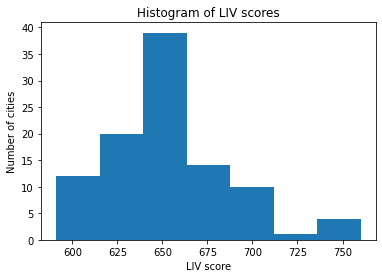

In [104]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(df["LIV"], bins = 7)

# set x/y labels and plot title
plt.pyplot.xlabel("LIV score")
plt.pyplot.ylabel("Number of cities")
plt.pyplot.title("Histogram of LIV scores")

Determine the Top 5 of each of the categories studied in the livability.com report

In [105]:
top5_LIV=df[['City','LIV']].sort_values('LIV', ascending=False)
top5_CI=df[['City','CI']].sort_values('CI', ascending=False).reset_index(drop=True)
top5_DE=df[['City','DE']].sort_values('DE', ascending=False).reset_index(drop=True)
top5_EC=df[['City','EC']].sort_values('EC', ascending=False).reset_index(drop=True)
top5_ED=df[['City','ED']].sort_values('ED', ascending=False).reset_index(drop=True)
top5_HE=df[['City','HE']].sort_values('HE', ascending=False).reset_index(drop=True)
top5_HO=df[['City','HO']].sort_values('HO', ascending=False).reset_index(drop=True)
top5_IN=df[['City','IN']].sort_values('IN', ascending=False).reset_index(drop=True)

In [106]:
print(top5_LIV.head())
print(top5_CI.head())
print(top5_DE.head())
print(top5_EC.head())
print(top5_ED.head())
print(top5_HE.head())
print(top5_HO.head())
print(top5_IN.head())

                     City  LIV
0  Fort Collins, Colorado  760
1     Ann Arbor, Michigan  759
2      Madison, Wisconsin  758
3         Portland, Maine  744
4    Rochester, Minnesota  727
                  City  CI
0      Carmel, Indiana  89
1   Oak Park, Illinois  85
2  Franklin, Tennessee  84
3  Ann Arbor, Michigan  84
4   Columbia, Maryland  80
                       City  DE
0   Jersey City, New Jersey  93
1  Providence, Rhode Island  88
2    New Haven, Connecticut  85
3       St. Paul, Minnesota  76
4    Sacramento, California  76
                    City  EC
0      Lansing, Michigan  78
1     Loveland, Colorado  75
2        Tucson, Arizona  75
3  Vancouver, Washington  73
4    Spokane, Washington  68
                     City  ED
0       Marietta, Georgia  75
1  Overland Parks, Kansas  74
2    Gainesville, Florida  74
3     Ann Arbor, Michigan  73
4    Bloomington, Indiana  72
                    City  HE
0        Iowa City, Iowa  79
1   Rochester, Minnesota  79
2     Madison, Wisc

Calculate the index of each category for Fort Collins, Colorado.

In [107]:
it='Fort Collins, Colorado'
print(top5_LIV[top5_LIV['City']==it])
print(top5_CI[top5_CI['City']==it])
print(top5_DE[top5_DE['City']==it])
print(top5_EC[top5_EC['City']==it])
print(top5_ED[top5_ED['City']==it])
print(top5_HO[top5_HO['City']==it])
print(top5_HE[top5_HE['City']==it])
print(top5_IN[top5_IN['City']==it])

                     City  LIV
0  Fort Collins, Colorado  760
                      City  CI
14  Fort Collins, Colorado  72
                      City  DE
74  Fort Collins, Colorado  42
                      City  EC
12  Fort Collins, Colorado  65
                     City  ED
9  Fort Collins, Colorado  71
                      City  HO
15  Fort Collins, Colorado  62
                      City  HE
15  Fort Collins, Colorado  69
                     City  IN
7  Fort Collins, Colorado  67


Determine the top 5 cities for each venue category extracted from FourSquare's API

In [109]:
top5_food=new_df[['City','Food venues']].sort_values('Food venues', ascending=False).reset_index(drop=True)
top5_drinks=new_df[['City','Drinks venues']].sort_values('Drinks venues', ascending=False).reset_index(drop=True)
top5_coffee=new_df[['City','Coffee venues']].sort_values('Coffee venues', ascending=False).reset_index(drop=True)
top5_arts=new_df[['City','Arts venues']].sort_values('Arts venues', ascending=False).reset_index(drop=True)
top5_outdoors=new_df[['City','Outdoors venues']].sort_values('Outdoors venues', ascending=False).reset_index(drop=True)
top5_sights=new_df[['City','Sights venues']].sort_values('Sights venues', ascending=False).reset_index(drop=True)

In [110]:
print(top5_food.head())
print(top5_drinks.head())
print(top5_coffee.head())
print(top5_arts.head())
print(top5_outdoors.head())
print(top5_sights.head())

                         City  Food venues
0      Sacramento, California           76
1  Charleston, South Carolina           71
2    Columbia, South Carolina           71
3       Vancouver, Washington           70
4        La Crosse, Wisconsin           70
                         City  Drinks venues
0  Wilmington, North Carolina             58
1            Des Moines, Iowa             57
2            Orlando, Florida             54
3    Providence, Rhode Island             51
4                Boise, Idaho             46
                       City  Coffee venues
0       Champaign, Illinois             48
1    Sacramento, California             40
2    Bellingham, Washington             37
3  Providence, Rhode Island             34
4            Tempe, Arizona             32
                         City  Arts venues
0        Santa Fe, New Mexico           56
1  Charleston, South Carolina           42
2      Grand Rapids, Michigan           41
3   Asheville, North Carolina           40

Determine the average number of each venue category, and plot them in a bar chart:

In [111]:
average_venues= new_df[['Food venues','Drinks venues','Coffee venues','Arts venues','Outdoors venues','Sights venues']].mean(axis=0)

<BarContainer object of 6 artists>

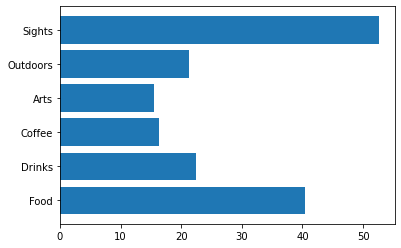

In [112]:
plt.pyplot.barh(['Food','Drinks','Coffee','Arts','Outdoors','Sights'],average_venues)